## Setup

In [12]:
!pip install swifter neuralprophet plotly kaleido statsmodels pmdarima swifter matplotlib seaborn plotly numpy pandas

In [13]:
import pandas as pd
import numpy as np
import typing
import matplotlib.pyplot as plt
import swifter
import dateutil
import datetime
import plotly
import tqdm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from pmdarima.model_selection import train_test_split

from gluonts.dataset.pandas import PandasDataset
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator

## Data preparation

### Loading data

In [14]:
df_tribunal = pd.read_csv('dados/processados/serie_temporal_ajuizamento-TJRN_G1_2018.csv', header='infer', sep=';')
print(df_tribunal.head(2))
#df_tribunal['data_ajuizamento'] = df_tribunal['data_ajuizamento'].swifter.apply(dateutil.parser.parse)
#df_tribunal['data_ajuizamento'] = df_tribunal['data_ajuizamento'].swifter.apply(datetime.datetime.date)


   Unnamed: 0  numero_processo tribunal  classe_codigo data_ajuizamento  \
0           0     1.002679e+18     TJRN            261       2018-04-23   
1           1     1.004497e+18     TJRN            279       2019-06-20   

   codigo_orgaoJulgador grau  
0                  5981   G1  
1                  5966   G1  


In [15]:
df_tribunal = df_tribunal[df_tribunal['data_ajuizamento'] < '2025-01-01']

In [16]:
dataframe = df_tribunal.groupby(['data_ajuizamento']).size()
df_tribunal = dataframe.to_frame(name='quantidade')
df_tribunal = df_tribunal.rename_axis('data_ajuizamento').reset_index()
print(df_tribunal)

     data_ajuizamento  quantidade
0          2018-01-01           8
1          2018-01-02          73
2          2018-01-03          82
3          2018-01-04         122
4          2018-01-05          12
...               ...         ...
2310       2024-05-03         320
2311       2024-05-04          91
2312       2024-05-05          51
2313       2024-05-06         559
2314       2024-05-07         383

[2315 rows x 2 columns]


In [17]:
#df_tribunal['data_ajuizamento'] = pd.to_datetime(df_tribunal['data_ajuizamento'])

### Visualização dos dados

Série Temporal dos ajuizamentos ao longo do tempo

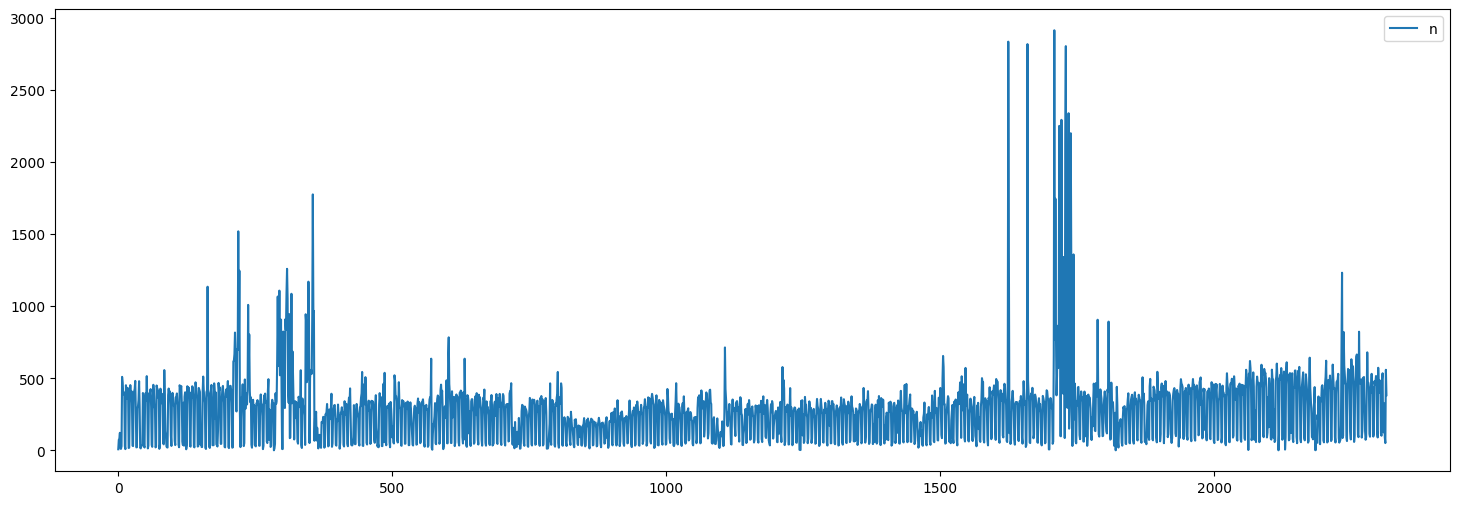

In [18]:
plt.figure(figsize=(18, 6))
plt.plot(df_tribunal['quantidade'])
plt.legend('número de ajuizamentos')

## Análise estatística

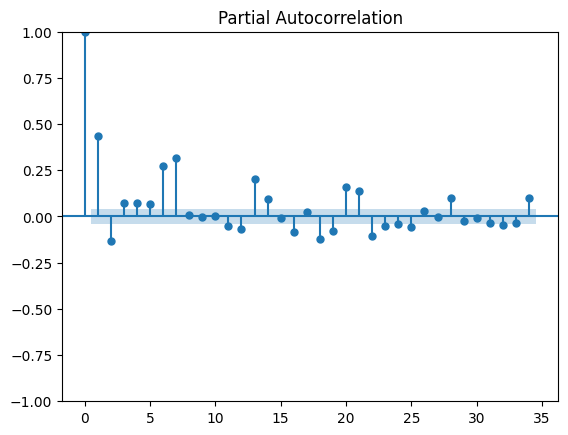

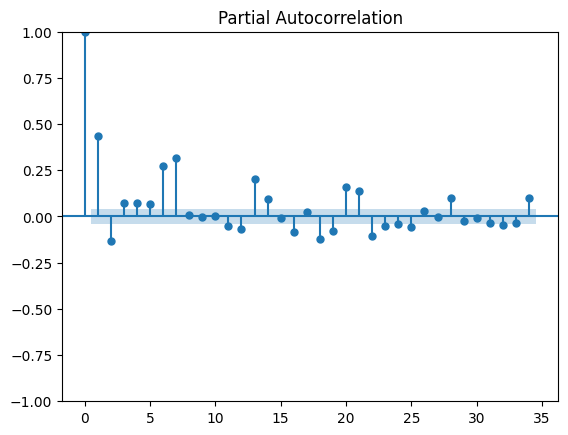

In [19]:
## PACF

df_pacf = df_tribunal
df_pacf.set_index('data_ajuizamento', inplace=True)
plot_pacf(df_pacf)

In [20]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df_pacf.quantidade.values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

if pval < 0.5:
    print('\n\nA série temporal é estacionária')
else:
    print('\n\nA série temporal não é estacionária')

ADF test statistic: -5.978759473026035
ADF p-values: 1.860132850939429e-07
ADF number of lags used: 27
ADF number of observations: 2287
ADF critical values: {'1%': -3.4332125513481744, '5%': -2.86280460821553, '10%': -2.5674432086780112}
ADF best information criterion: 30320.37777572633


A série temporal é estacionária


# Métodos e modelos

## GLUONTS
### DeepAR

In [ ]:
def train_and_predict(dataset, estimator):
    predictor = estimator.train(dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset, predictor=predictor
    )
    evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:])
    agg_metrics, item_metrics = evaluator(ts_it, forecast_it, num_series=len(dataset))
    return agg_metrics["MSE"]

def highlight_entry(entry, color):
    start = entry["start"]
    end = entry["start"] + len(entry["target"])
    plt.axvspan(start, end, facecolor=color, alpha=0.2)


def plot_dataset_splitting(original_dataset, training_dataset, test_pairs):
    for original_entry, train_entry in zip(original_dataset, training_dataset):
        to_pandas(original_entry).plot()
        highlight_entry(train_entry, "red")
        plt.legend(["sub dataset", "training dataset"], loc="upper left")
        plt.show()

    for original_entry in original_dataset:
        for test_input, test_label in test_pairs:
            to_pandas(original_entry).plot()
            highlight_entry(test_input, "green")
            highlight_entry(test_label, "blue")
            plt.legend(["sub dataset", "test input", "test label"], loc="upper left")
            plt.show()

In [ ]:
ds = PandasDataset(ts, target="quantidade", freq='D')
splitter = DateSplitter(
    date=pd.Period('2022-01-01', freq='D')
)
train, test_template = splitter.split(ds)
test_dataset = test_template.generate_instances(
    prediction_length=14,
    windows=5,
)

estimator = DeepAREstimator(
    freq=freq, prediction_length=prediction_length, trainer=Trainer(epochs=1)
)

predictor = estimator.train(train)
forecast_it, ts_it = make_evaluation_predictions(dataset=test, predictor=predictor)
forecasts = list(forecast_it)
tests = list(ts_it)
evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:])
agg_metrics, item_metrics = evaluator(tests, forecasts, num_series=len(test))

estimator = DeepAREstimator(
    freq=ds.freq, prediction_length=7, trainer=Trainer(epochs=10)
)
predictor = estimator.train(ds)
print(train_and_predict(ds, estimator))
plot_dataset_splitting(ds, train, test_dataset)

In [ ]:
n_plot = 3
indices = np.random.choice(np.arange(0, N), size=n_plot, replace=False)
fig, axes = plt.subplots(n_plot, 1, figsize=(10, n_plot * 5))
for index, ax in zip(indices, axes):
    ax.plot(tests[index][-4 * prediction_length :].to_timestamp())
    plt.sca(ax)
    forecasts[index].plot(intervals=(0.9,), color="g")
    plt.legend(["observed", "predicted median", "90% prediction interval"])